# SMS Spam Detection System

## Authors: Temirlan Ismukhanov, Zhandos Sembay


## Description: 

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')


# Text Preprocessing
import nltk

from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize



# Show Statistics

In [2]:
messages = pd.read_csv("spam.csv", encoding = 'latin-1')

# Drop the extra columns and rename columns

messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["category", "text"]

In [3]:
display(messages.head(n = 20))

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
category    5572 non-null object
text        5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


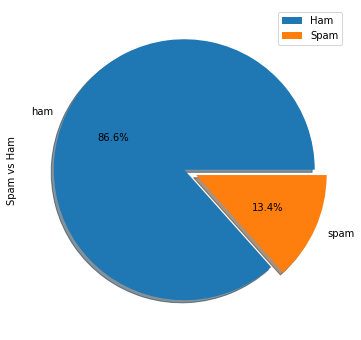

In [5]:
messages["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [6]:
topMessages = messages.groupby("text")["category"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(topMessages)

,len,amax
text,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,4,spam
Okie,4,ham
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4,ham
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\""... good morning dear""",4,ham


In [7]:
spam_messages = messages[messages["category"] == "spam"]["text"]
ham_messages = messages[messages["category"] == "ham"]["text"]

spam_words = []
ham_words = []

# Since this is just classifying the message as spam or ham, we can use isalpha(). 
# This will also remove the not word in something like can't etc. 
# In a sentiment analysis setting, its better to use 
# sentence.translate(string.maketrans("", "", ), chars_to_remove)

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
7       None
10      None
13      None
14      None
16      None
17      None
18      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
30      None
31      None
32      None
33      None
35      None
36      None
37      None
38      None
        ... 
5538    None
5539    None
5541    None
5542    None
5543    None
5544    None
5545    None
5546    None
5548    None
5549    None
5550    None
5551    None
5552    None
5553    None
5554    None
5555    None
5556    None
5557    None
5558    None
5559    None
5560    None
5561    None
5562    None
5563    None
5564    None
5565    None
5568    None
5569    None
5570    None
5571    None
Name: text, Length: 4825, dtype: object

In [10]:
# Top 10 spam words

spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
pd.Series(spam_words).value_counts().head(n = 10)

Top 10 Spam words are :



call      346
free      217
txt       156
ur        144
u         144
mobile    123
text      121
stop      114
claim     113
reply     104
dtype: int64

In [11]:
# Top 10 Ham words

ham_words = np.array(ham_words)
print("Top 10 Ham words are :\n")
pd.Series(ham_words).value_counts().head(n = 10)

Top 10 Ham words are :



u       974
gt      318
lt      316
get     301
ok      246
go      246
got     242
ur      237
know    234
like    231
dtype: int64

In [12]:
messages["messageLength"] = messages["text"].apply(len)
messages["messageLength"].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: messageLength, dtype: float64

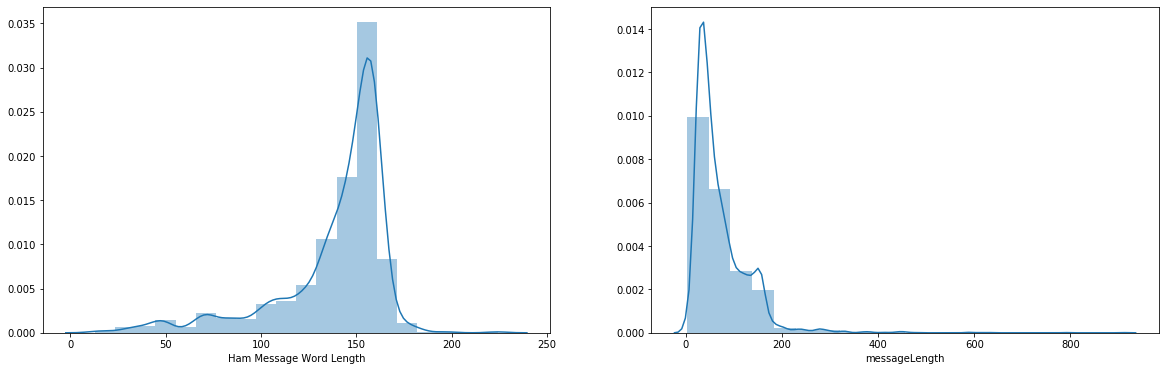

In [13]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.distplot(messages[messages["category"] == "spam"]["messageLength"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(messages[messages["category"] == "ham"]["messageLength"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Ham Message Word Length")

plt.show()

# 1. Import dataset 

In [14]:
sms = pd.read_csv("spam.csv", encoding = "ISO-8859-1", usecols=[0,1], skiprows=1,names=["label", "message"])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
sms.label = sms.label.map({"ham":0, "spam":1})

In [16]:
# more negative (ham) cases than positive (spam)
sms.label.value_counts()

0    4825
1     747
Name: label, dtype: int64

# 2. Split into train and test sets

In [18]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(sms.message, sms.label, test_size=0.2)

# 3. Create Document Train Matrix

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

couvec = CountVectorizer()
couvec.fit(features_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [20]:
# number of features or tokens
trained_features = couvec.get_feature_names()
print("Number of features vectorized:", len(trained_features))
print("Examples of trained features:", trained_features[1:10])

Number of features vectorized: 7750
Examples of trained features: ['000', '000pes', '008704050406', '0089', '01223585236', '01223585334', '0125698789', '02', '0207']


In [21]:
# tokenized train documents
dtm_train = couvec.fit_transform(features_train)
print("Shape of dtm_train:", dtm_train.shape)
print(dtm_train[0:2]) # first two rows of sparse matrix

Shape of dtm_train: (4457, 7750)
  (0, 4210)	1
  (0, 7206)	1
  (0, 1194)	1
  (0, 3161)	1
  (0, 6821)	1
  (1, 7063)	1
  (1, 4942)	1
  (1, 5989)	1
  (1, 7698)	1
  (1, 1045)	1
  (1, 848)	1
  (1, 6894)	1
  (1, 749)	1
  (1, 5068)	1
  (1, 6926)	1
  (1, 6445)	1
  (1, 926)	1
  (1, 4823)	1
  (1, 1082)	1
  (1, 1565)	1
  (1, 7603)	1
  (1, 6330)	2
  (1, 4799)	1
  (1, 5931)	1
  (1, 3181)	1


In [22]:
# tokenized test documents
dtm_test = couvec.transform(features_test)
print("Shape of dtm_test:", dtm_test.shape)

Shape of dtm_test: (1115, 7750)


# 4. Building and evaluating a model

In [23]:
# import and instantiate Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [24]:
# train the model
nb.fit(dtm_train, labels_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
# make predictions
labels_pred = nb.predict(dtm_test)

In [26]:
# accuracy not an important metric when positive and negative classes are skewed
from sklearn import metrics
metrics.accuracy_score(labels_test, labels_pred)

0.9847533632286996

In [27]:
# create confusion matrix to see precision and recall
metrics.confusion_matrix(labels_test, labels_pred)

array([[956,   5],
       [ 12, 142]])

In [28]:
# percentage of total spam detected i.e.recall
print("Recall:", metrics.recall_score(labels_test, labels_pred))
# percentage of positive (spam) predictions that are correct i.e. precision
print("Precision:", metrics.precision_score(labels_test, labels_pred))

Recall: 0.922077922077922
Precision: 0.9659863945578231


In [29]:
print("Order of classes in predict_proba:", nb.classes_)
print("Example class probabilities:", nb.predict_proba(dtm_test)[0])

Order of classes in predict_proba: [0 1]
Example class probabilities: [9.99990259e-01 9.74055342e-06]


In [30]:
# since only ~15% of labels are positive (spam), a precision-recall curve is more useful than
# ROC curve
labels_prob = nb.predict_proba(dtm_test)[:, 1]
precisions, recalls, thresholds = metrics.precision_recall_curve(labels_test, 
                                                                 labels_prob)

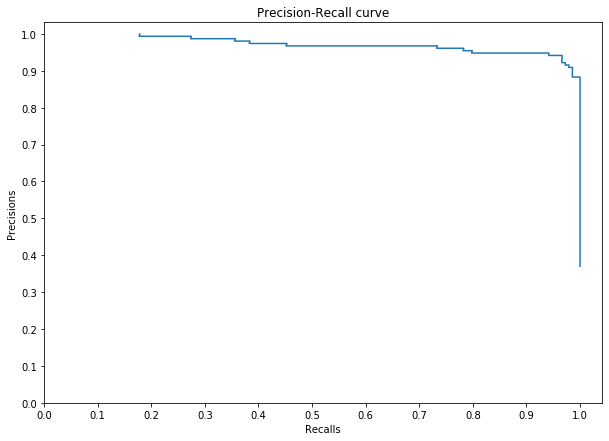

In [31]:
# plotting precision-recall curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisions")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Precision-Recall curve")
plt.show()